In [9]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import mixture

In [10]:
#load data
data = pd.read_csv('data/milk_join.csv')
data.set_index('ROW')

print data.columns

Index([u'ROW', u'SYSTEM', u'COUNTY', u'MRKTCODE', u'VENDOR', u'MONTH', u'DAY',
       u'YEAR', u'LFC', u'LFW', u'WW', u'WC', u'QLFC', u'QLFW', u'QWW', u'QWC',
       u'ESTQTY', u'QUANTITY', u'FMOZONE', u'DEL', u'ESC', u'COOLER', u'MILES',
       u'WIN', u'NUMSCHL', u'NUMWIN', u'I', u'GAS', u'FMO', u'N', u'BACKLOG'],
      dtype='object')


In [11]:
#ESC, COOLER ,MILES, GAS, DEL, ESTQTY
reg1 = data[['WW', 'FMO','ESC', 'NUMSCHL','MILES','COOLER', 'GAS','DEL','ESTQTY']].dropna()

#make a little better
reg1['NUMSCHL'] = np.maximum(reg1['NUMSCHL'],1)
reg1['NOSTOP'] = reg1['NUMSCHL']*reg1['DEL']
reg1['MILES'] =reg1['MILES']+1
reg1 = reg1[reg1['WW']<=.3]

#log scale
reg1[['WW', 'FMO', 'MILES', 'GAS','NOSTOP', 'ESTQTY']] = np.log(
                                            reg1[['WW', 'FMO', 'MILES', 'GAS', 'NOSTOP', 'ESTQTY']])

print reg1.mean()

WW         -1.768216
FMO         2.672613
ESC         0.737441
NUMSCHL    12.544541
MILES       3.456749
COOLER      0.736772
GAS         2.864354
DEL         4.262827
ESTQTY     12.857605
NOSTOP      3.346037
dtype: float64


In [39]:
reg1 = data[['WW','FMO']].dropna()
reg1 = reg1[reg1['WW']<.4]
reg1 = np.log(reg1)
model = sm.OLS(reg1['WW'],sm.add_constant(reg1['FMO']))
result = model.fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                     WW   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     138.9
Date:                Sun, 21 Apr 2019   Prob (F-statistic):           1.60e-31
Time:                        19:30:51   Log-Likelihood:                 3793.9
No. Observations:                3925   AIC:                            -7584.
Df Residuals:                    3923   BIC:                            -7571.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6225      0.071    -37.034      0.0

Means: [ 0.02869502 -0.04314301]
Var: [0.00202189 0.01507081]
Weights: [0.6005595 0.3994405]


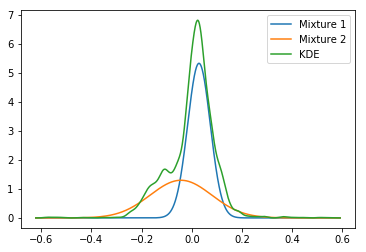

In [40]:
#fit mixture model
g = mixture.GaussianMixture(n_components=2)
g.fit(np.array([result.resid]).transpose())


print 'Means: %s'%g.means_[:,0]
print 'Var: %s'%g.covariances_[:,0,0]
print 'Weights: %s'%g.weights_

#do kernel density estimation
dens = sm.nonparametric.KDEUnivariate(result.resid)
dens.fit()


#graph kernel with mixture components
comp1 = g.weights_[0]*stats.norm.pdf(dens.support,g.means_[0,0],g.covariances_[0,0]**.5)
comp2 = g.weights_[1]*stats.norm.pdf(dens.support,g.means_[1,0],g.covariances_[1,0]**.5)

plt.plot(dens.support, comp1, label='Mixture 1')
plt.plot(dens.support, comp2, label='Mixture 2')
plt.plot(dens.support, dens.density, label='KDE')
plt.legend()
plt.show()


-1.78932530075667
Means: [ 0.02191804 -0.05777944]
Var: [0.00301345 0.02171865]
Weights: [0.72498447 0.27501553]


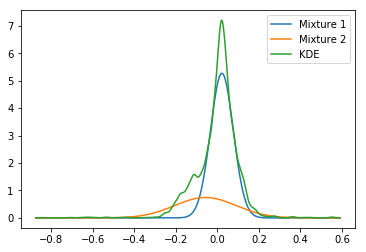

In [32]:
bids = np.array(data['WW'].dropna())

#log transformation
lbids = np.log(bids[ bids<=.4 ])
print lbids.mean()
lbids = lbids - lbids.mean()


#fit mixture model
g = mixture.GaussianMixture(n_components=2)
g.fit(lbids.reshape(lbids.shape[0],1))


print 'Means: %s'%g.means_[:,0]
print 'Var: %s'%g.covariances_[:,0,0]
print 'Weights: %s'%g.weights_

#do kernel density estimation
dens = sm.nonparametric.KDEUnivariate(lbids)
dens.fit()


#graph kernel with mixture components
comp1 = g.weights_[0]*stats.norm.pdf(dens.support,g.means_[0,0],g.covariances_[0,0]**.5)
comp2 = g.weights_[1]*stats.norm.pdf(dens.support,g.means_[1,0],g.covariances_[1,0]**.5)

plt.plot(dens.support, comp1, label='Mixture 1')
plt.plot(dens.support, comp2, label='Mixture 2')
plt.plot(dens.support, dens.density, label='KDE')
plt.legend()
plt.show()
